## Traininig of the High Level Feature classifier

**4.1 HLF classifier** This trains the Particle Sequence classifier model using BigDL and Analytics Zoo

To run this notebook we used the following configuration:
* *Software stack*: Spark 2.4.3, analytics-zoo 0.5.1
* *Platform*: CentOS 7, Python 3.6
* *CERN Spark cluster*: Hadalytic

In [1]:
# pip install pyspark or use your favorite way to set Spark Home, here we use findspark
import findspark
findspark.init('/home/luca/Spark/spark-2.4.3-bin-hadoop2.7') #set path to SPARK_HOME

In [2]:
# Configure according to your environment
from pyspark.sql import SparkSession

pyspark_python = "<path to python>/bin/python"
analytics_zoo_jar = "<path>/analytics-zoo-bigdl_0.8.0-spark_2.4.3-0.5.1-jar-with-dependencies.jar"
analytics_zoo_python_api = "<path>/analytics-zoo-bigdl_0.8.0-spark_2.4.3-0.5.1-python-api.zip"

spark = SparkSession.builder \
        .appName("4.1-Training-HLFClassifier") \
        .master("yarn") \
        .config("spark.driver.memory","4g") \
        .config("spark.executor.memory","4g") \
        .config("spark.executor.cores","6") \
        .config("spark.executor.instances","24") \
        .config("spark.dynamicAllocation.enabled","false") \
        .config("spark.shuffle.reduceLocality.enabled","false") \
        .config("spark.shuffle.blockTransferService","nio") \
        .config("spark.scheduler.minRegisteredResourcesRatio","1.0") \
        .config("spark.speculation","false") \
        .config("spark.eventLog.enabled","false") \
        .config("spark.jars",analytics_zoo_jar) \
        .config("spark.submit.pyFiles",analytics_zoo_python_api) \
        .config("spark.pyspark.python",pyspark_python) \
        .getOrCreate()

In [3]:
# Check if Spark Session has been created correctly
spark

## Load the training and test dataset

In [4]:
#PATH = "hdfs://analytix/Training/Spark/TopologyClassifier/"
PATH = "/project/ML/data/"

trainDF = spark.read.format('parquet')\
        .load(PATH + 'trainUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])
        
testDF = spark.read.format('parquet')\
        .load(PATH + 'testUndersampled.parquet')\
        .select(['HLF_input', 'encoded_label'])

In [5]:
trainDF.printSchema()

root
 |-- HLF_input: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)



In [6]:
print("Number of events in the test dataset:", testDF.count())

print("Number of events in the training dataset:", trainDF.count())

Number of events in the test dataset: 856090
Number of events in the training dataset: 3426083


## Traininig and validation data use DataFrames

No need to change to RDD of Sample, just use dataframe

We can see the 14 high level features (`shape=[14]`) and the encoded label (`shape=[3]`).

In [7]:
# Let's have a look at one element of trainDF
trainDF.show(1, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|HLF_input                                                                                                                                                                                                 |encoded_label|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|[0.03668947581127577,0.006877581331222466,0.11903604928482604,0.003224928361347901,0.2,0.125,0.0438427274338726,0.6820271142680264,0.5391943416500768,0.07416676582260869,0.03257989514569496,0.0,0.0,0.0]|(3,[1],[1.0])|
+---------------------------------------------------------------------------------------------------------------------------

## Create the model

In [8]:
# Init analytics zoo
from zoo.common.nncontext import *
sc = init_nncontext("hlf classifier")

In [9]:
sc

<SparkContext master=yarn appName=4.1-Training-HLFClassifier>

In [10]:
# Create keras like zoo model.
# Only need to change package name from keras to zoo.pipeline.api.keras

from zoo.pipeline.api.keras.optimizers import Adam
from zoo.pipeline.api.keras.models import Sequential
from zoo.pipeline.api.keras.layers.core import Dense, Activation

model = Sequential()
model.add(Dense(50, input_shape=(14,), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense


## Estimator setup and training

In [11]:
# Set of hyperparameters
numEpochs = 12

# The batch used by BDL must be a multiple of numExecutors * executorCores
# Because data will be equally distibuted inside each executor

workerBatch = 128

numExecutors = int(sc._conf.get('spark.executor.instances'))

executorCores = int(sc._conf.get('spark.executor.cores'))

BDLbatch = workerBatch * numExecutors * executorCores

In [12]:
# Create SparkML compatible estimator for deep learning training

from bigdl.optim.optimizer import EveryEpoch, Loss, TrainSummary, ValidationSummary
from zoo.pipeline.nnframes import *
from zoo.pipeline.api.keras.objectives import CategoricalCrossEntropy

estimator = NNEstimator(model, CategoricalCrossEntropy()) \
        .setOptimMethod(Adam()) \
        .setBatchSize(BDLbatch) \
        .setMaxEpoch(numEpochs) \
        .setFeaturesCol("HLF_input") \
        .setLabelCol("encoded_label") \
        .setValidation(trigger=EveryEpoch() , val_df=testDF,
                       val_method=[Loss(CategoricalCrossEntropy())], batch_size=BDLbatch)

creating: createZooKerasCategoricalCrossEntropy
creating: createSeqToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createZooKerasAdam
creating: createDefault
creating: createEveryEpoch
creating: createZooKerasCategoricalCrossEntropy
creating: createLoss


Let's define a directory to store logs (i.e. train and validation losses) and save models

In [13]:
# name of our application
appName = "HLFclassifier"

# Change it! 
logDir = "/tmp"

# Check if there is already an application with the same name 
# and remove it, otherwise logs will be appended to that app
import os
try:
    os.system('rm -rf '+logDir+'/'+appName)
except:
    pass

print("Saving logs to {}".format(logDir+'/'+appName))

Saving logs to /tmp/HLFclassifier


In [14]:
trainSummary = TrainSummary(log_dir=logDir,app_name=appName)
estimator.setTrainSummary(trainSummary)

valSummary = ValidationSummary(log_dir=logDir,app_name=appName)
estimator.setValidationSummary(valSummary)

creating: createTrainSummary
creating: createValidationSummary


NNEstimator_75b4bcdb78f7

# Launch model training

This will launch the distributed training. As a first step it will cache in the executor blockmanagers storage the relevant training and validation dataframes.  
Warning relevant when using CERN SWAN: During the training it would be better to shutdown the Toggle Spark Monitoring Display because each iteration is seen as a Spark job, therefore the toggle will try to display everything causing problem to the browser. 

In [15]:
%time trained_model = estimator.fit(trainDF)

creating: createToTuple
creating: createChainedPreprocessing
CPU times: user 34.1 ms, sys: 11 ms, total: 45.1 ms
Wall time: 4min 25s


## Plot loss

<IPython.core.display.Javascript object>


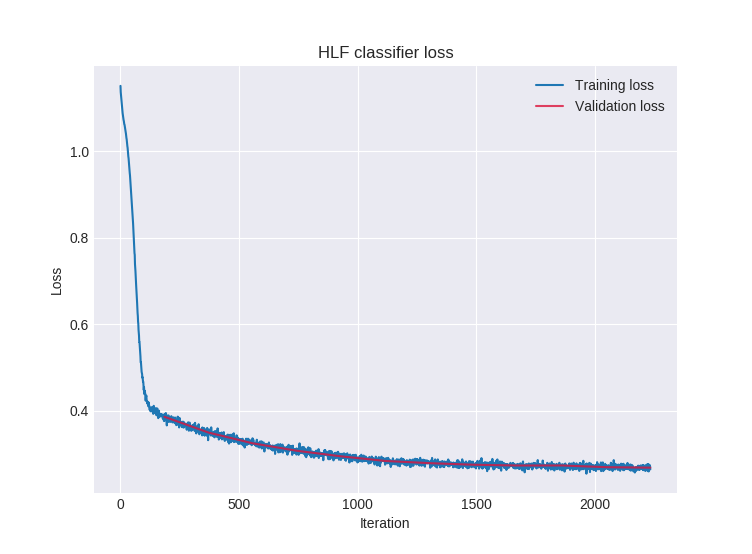

In [16]:
%matplotlib notebook

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


loss = np.array(trainSummary.read_scalar("Loss"))
val_loss = np.array(valSummary.read_scalar("Loss"))

plt.plot(loss[:,0], loss[:,1], label="Training loss")
plt.plot(val_loss[:,0], val_loss[:,1], label="Validation loss", color='crimson', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title("HLF classifier loss")
plt.show()

## Save the model

In [17]:
modelDir = logDir + '/models'
trained_model.save(modelDir + '/HLFClassifier')

NNModel_805b530020c8

**Note:** It is possible to load the model in the following way:
```Python
from zoo.pipeline.nnframes import *
trained_model = NNModel.load(path=modelDir + '/HLFClassifier')
```

In [17]:
# from zoo.pipeline.nnframes import *
# modelDir='/tmp/models'
# trained_model = NNModel.load(path=modelDir+'/HLFClassifier')

## Prediction

In [18]:
# Predict with trained NNModel using pipeline transform API
predDF = trained_model.transform(testDF)

In [19]:
predDF.printSchema()

root
 |-- HLF_input: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)
 |-- prediction: array (nullable = false)
 |    |-- element: float (containsNull = false)



In [20]:
y_pred = np.asarray(predDF.select("prediction").collect())
y_true = np.asarray(testDF.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [21]:
y_pred = np.squeeze(y_pred)
y_pred.shape

(856090, 3)

In [22]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


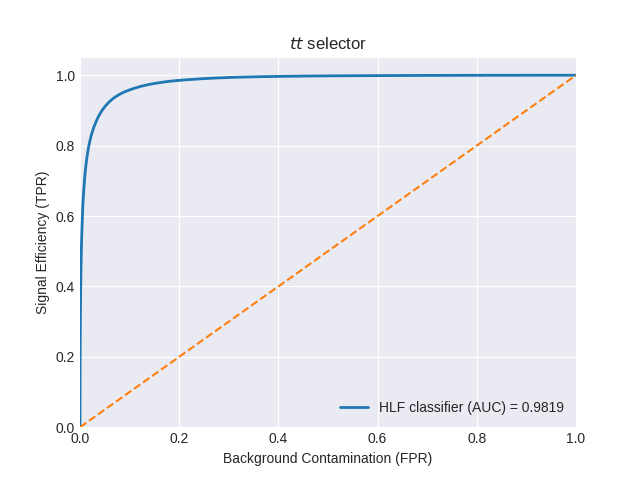

In [23]:
plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix

In [24]:
from sklearn.metrics import accuracy_score

print('Accuracy of the Inclusive classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the Inclusive classifier: 0.9017


<IPython.core.display.Javascript object>


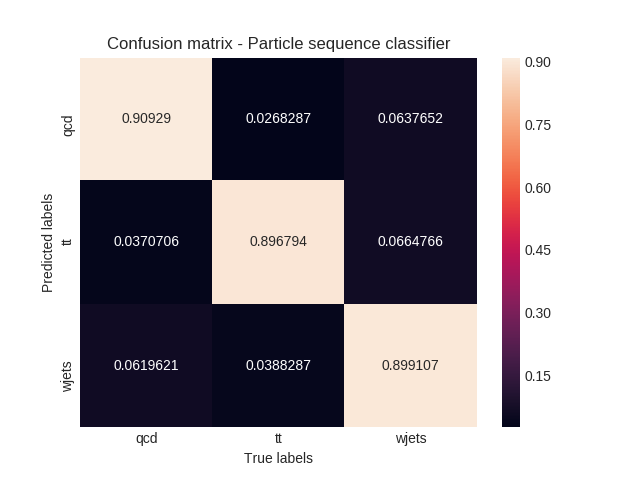

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.title('Confusion matrix - Particle sequence classifier')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [28]:
spark.stop()